In [ ]:
from google.colab import drive
drive.mount('/content/drive')

filepath='/content/drive/My Drive/UCB Research/'

Mounted at /content/drive


In [ ]:
!pip install mpnum

     |████████████████████████████████| 78 kB 3.1 MB/s 


In [ ]:
import numpy as np
import functools as ft
import numpy.linalg as la
from scipy.sparse import lil_matrix, kron, identity, csr_matrix, random
from scipy.sparse.linalg import eigsh, norm, svds
from scipy.stats import unitary_group
#from cupyx.scipy.sparse.linalg import eigsh
import mpnum
import time
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from decimal import Decimal

In [ ]:
N=64
d=2
max_rank=256

### SVD

In [ ]:
def Entangle(mpa,method='mps'):
  N=len(mpa)
  rank=max(mpa.ranks)

  if method=='full':
    #Warning: Full method can lead to memory run-offs. 
    psi=mpa.to_array()

  else:
    mpa.canonicalize(left=N//2-1, right=N//2)
    #print(mpa.canonical_form)

    M=mpa.lt
    psi=np.tensordot(M[N//2-1],M[N//2],axes=(-1,0))
  
  psi_shape=int(np.sqrt(psi.size))
  psi=np.reshape(psi,(psi_shape,psi_shape))
  
  S=la.svd(psi,compute_uv=False)
  #print(la.norm(S))
  S=S/la.norm(S)

  S2=np.abs(S)
  EE=-np.sum(S2**2*np.log2(S2**2+1e-32)) #Add eps=1e-32 to avoid log(0) error.
  return EE, S

### AGSP

In [ ]:
def AGSP():
  x = unitary_group.rvs(4)
  D=np.diag([1,1,0,0])
  loc_op = x@D@x.T.conj()

  loc_op=loc_op.reshape((2,2,2,2))
  loc_op=mpnum.MPArray.from_array_global(loc_op,ndims=2)

  DL_even = mpnum.factory.eye(sites=1, ldim=d)
  DL_odd = loc_op  

  for i in range(N//2-1):
    DL_odd = mpnum.chain([DL_odd, loc_op])
    DL_even = mpnum.chain([DL_even, loc_op])

  DL_even=mpnum.chain([DL_even, mpnum.factory.eye(sites=1, ldim=d)])

  A = mpnum.dot(DL_odd, DL_even)

  EE,S=Entangle(A,method='mpo')

  print('square of singular values:', (S[:4]**2).round(3))

  return A

### Operation

In [ ]:
def save(obj, file_name, file_type=None):
  def mpa_to_lt(a):
    res=[]
    for i in range(len(a)):
      res.append(a.lt[i])
    return res

  if file_type=='mpa':
    obj_lt=mpa_to_lt(obj)

    with open(filepath+'Data2/'+file_name+'.pkl', 'wb') as output:
      for i in range(N):
        pickle.dump(gs_lt[i], output, pickle.HIGHEST_PROTOCOL)
  else: 
    with open(filepath+'Data2/'+file_name+'.pkl', 'wb') as output:
      pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load(file_name, file_type=None):
  if file_type=='mpa':
    mpa = []
    with open(filepath+'Data2/'+file_name+'.pkl', 'rb') as input:
      for i in range(N):
        mpa.append(pickle.load(input))
    return mpnum.MPArray(mpa)

  else:
    with open(filepath+'Data2/'+file_name+'.pkl', 'rb') as input:
        return pickle.load(input)

In [ ]:
def run_test(curr_iter, n_iter=8):
  rng = np.random.RandomState(seed=42)
  rank=1
  mpa = mpnum.random_mps(sites=N, ldim=d, rank=rank, randstate=rng)

  A=AGSP()
  save(A, 'AGSP'+str(curr_iter))

  S_hist=np.zeros((d*max_rank,0))
  EE_hist=[]
  norm_hist=[]

  for i in range(n_iter):
    tm=time.time()

    mpa = mpnum.dot(A,mpa)
    norm=mpnum.norm(mpa)
    mpa=mpa/norm

    EE,S=Entangle(mpa)
    EE_hist.append(EE)
    S_exp=np.zeros(d*max_rank)
    S_exp[:len(S)]=S[:d*max_rank]
    S_hist=np.concatenate((S_hist, S_exp.reshape(-1,1)), axis=1)

    new_rank = np.count_nonzero(S_hist[:,i]>1e-16, axis=0)

    mpa.compress(method='var',
                      rank=min(new_rank, max_rank),
                      num_sweeps=4)
    
    norm_hist.append(norm)
    print("Epoch: ",i+1,"\t Rank: ", new_rank, "\t Norm: ", '%.2E' % Decimal(norm), "\t Time: ",np.round(time.time()-tm,3))

  return S_hist, np.array(EE_hist), np.array(norm_hist)

In [ ]:
for i in range(100):
  S, EE, norm = run_test(i, n_iter=10)

  save(S, 'S'+str(i))
  save(EE, 'EE'+str(i))
  save(norm, 'norm'+str(i))

square of singular values: [0.549 0.436 0.009 0.007]
Epoch:  1 	 Rank:  2 	 Norm:  1.03E-12 	 Time:  0.537
Epoch:  2 	 Rank:  4 	 Norm:  6.32E-12 	 Time:  0.589
Epoch:  3 	 Rank:  8 	 Norm:  9.00E-11 	 Time:  0.64
Epoch:  4 	 Rank:  17 	 Norm:  3.43E-10 	 Time:  1.655
Epoch:  5 	 Rank:  36 	 Norm:  5.98E-10 	 Time:  4.117
Epoch:  6 	 Rank:  75 	 Norm:  7.41E-10 	 Time:  17.19
Epoch:  7 	 Rank:  153 	 Norm:  8.12E-10 	 Time:  89.413
Epoch:  8 	 Rank:  308 	 Norm:  8.50E-10 	 Time:  418.404
Epoch:  9 	 Rank:  457 	 Norm:  8.71E-10 	 Time:  921.878
Epoch:  10 	 Rank:  466 	 Norm:  8.84E-10 	 Time:  920.659
square of singular values: [0.796 0.187 0.013 0.003]
Epoch:  1 	 Rank:  2 	 Norm:  1.83E-10 	 Time:  0.519
Epoch:  2 	 Rank:  4 	 Norm:  2.21E-04 	 Time:  0.589
Epoch:  3 	 Rank:  8 	 Norm:  2.61E-03 	 Time:  0.657
Epoch:  4 	 Rank:  17 	 Norm:  6.27E-03 	 Time:  1.616
Epoch:  5 	 Rank:  35 	 Norm:  9.32E-03 	 Time:  4.093
Epoch:  6 	 Rank:  68 	 Norm:  1.12E-02 	 Time:  17.118
Epoch:  

### Plots

In [ ]:
#Loading Results

sample_size = 100
n_iter=10

S_hist=np.zeros((sample_size,d*max_rank,n_iter))
EE_hist=np.zeros((sample_size,n_iter))
norm_hist=np.zeros((sample_size,n_iter))

for i in range(sample_size):
  S_hist[i]=load('S'+str(i))
  EE_hist[i]=load('EE'+str(i))
  norm_hist[i]=load('norm'+str(i))


"\nsample_size = 24\nn_iter=5\n\nS_hist=np.zeros((sample_size,d*max_rank,n_iter))\nEE_hist=np.zeros((sample_size,n_iter))\nnorm_hist=np.zeros((sample_size,n_iter))\n\nfor i in range(sample_size):\n  S_hist[i]=load('S'+str(i))\n  EE_hist[i]=load('EE'+str(i))\n  norm_hist[i]=load('norm'+str(i))\n"

In [ ]:
x,y,z=S_hist[0,:3,1:]

x=np.log2(x)
y=np.log2(y)
z=np.log2(z)

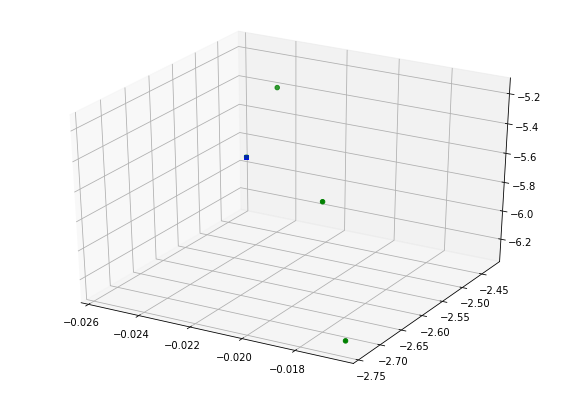

In [ ]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(x, y, z, color = "green")
ax.scatter3D(x[0], y[0], z[0], color = "blue",marker='s')
#ax.scatter3D(np.log2(S[0]),np.log2(S[1]),np.log2(S[2]), color = "r")

plt.show()

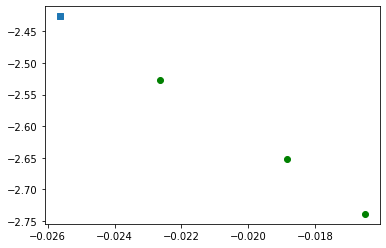

In [ ]:
plt.scatter(x[:],y[:],c='green')
plt.scatter(x[0],y[0],marker='s')
#plt.scatter(np.log2(S[0]),np.log2(S[1]),marker='*',c='r')

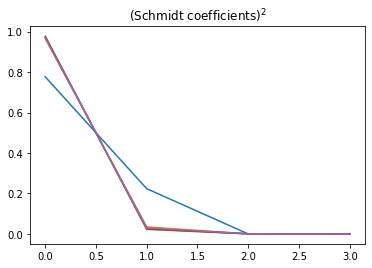

In [ ]:
plt.title('(Schmidt coefficients)$^2$')
plt.plot(np.arange(4),S_hist[0,:4,:6]**2)
plt.show()

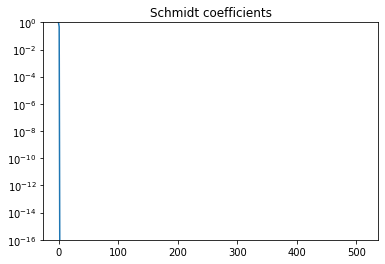

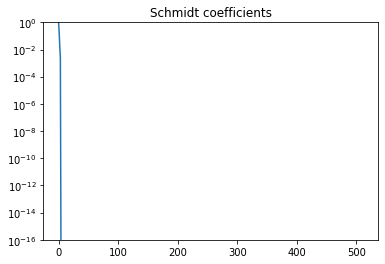

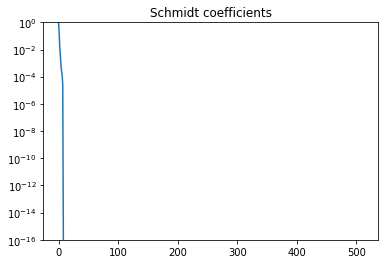

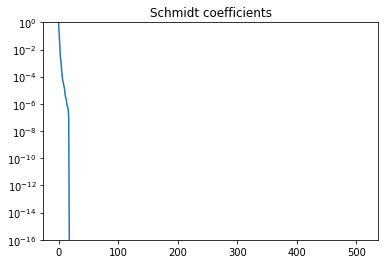

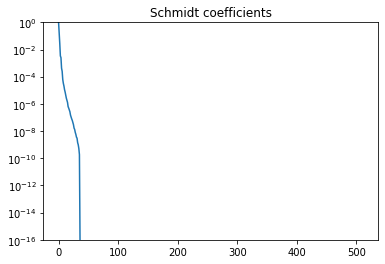

In [ ]:
for i in range(5):
  plt.semilogy(S_hist[:,:,i].T)
  plt.title('Schmidt coefficients')
  plt.ylim((1e-16,1))
  #plt.legend(np.arange(6,12))
  plt.show()

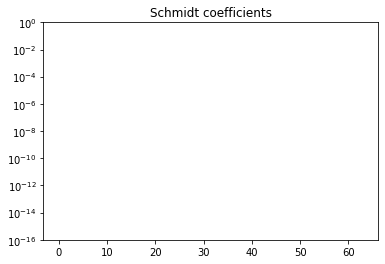

In [ ]:
plt.semilogy(S_hist[13,:max_rank//4,:20])
plt.title('Schmidt coefficients')
plt.ylim((1e-16,1))
#plt.legend(np.arange(6,12))
plt.show()

In [ ]:
ER=np.count_nonzero(S_hist>1e-16, axis=1)

In [ ]:
for i in range(sample_size):
  plt.semilogy(ER[i].T)
plt.title('Entanglement Rank')
plt.show()

In [ ]:
for i in range(sample_size):
  plt.plot(EE_hist[i].T)
  #plt.plot(np.log2(ER[i].T),'k-')
  #plt.hlines(EE,0,len(EE_hist)-1,colors='r',linestyles='dashed')
  plt.title('Entanglement Entropy')
plt.show()

In [ ]:
for i in range(sample_size):
  plt.plot(EE_hist[i].T)
  #plt.plot(np.log2(ER[i].T))
  #plt.hlines(EE,0,len(EE_hist)-1,colors='r',linestyles='dashed')
  plt.title('Entanglement Entropy')
  plt.show()

In [ ]:
#norm_hist=norm_hist/np.max(norm_hist,axis=1).reshape(sample_size,1)

$(XY)^N$

$X^{1/2} Y X^{1/2}$

$X^{1/2} YXYXYXY X^{1/2}$

In [ ]:
for i in range(sample_size):
  plt.semilogy(norm_hist[i,:6].T)
plt.title('Normalization Constant')
plt.show()

In [ ]:
plt.scatter(np.log10(norm_hist), ER) 

In [ ]:
for i in range(5):
  plt.scatter(np.log10(norm_hist[:,i]), ER[:,i])
plt.show()

In [ ]:
for i in range(10):
  plt.scatter(np.log10(norm_hist[:,i]/norm_hist[:,-1]), EE_hist[:,i])
plt.show()

In [ ]:
for i in range(sample_size):
  plt.scatter(norm_hist[i,:], ER[i,:])
  plt.show()

### Special Cases

In [ ]:
plt.plot(EE_hist[-3,:])

In [ ]:
plt.plot(S_hist[-3,:4,:10])
plt.title('Schmidt coefficients')
plt.ylim((1e-16,1))
#plt.legend(np.arange(6,12))
plt.show()

plt.semilogy(S_hist[-3,:max_rank,:10])
plt.title('Schmidt coefficients')
plt.ylim((1e-16,1))
#plt.legend(np.arange(6,12))
plt.show()

In [ ]:
log_norm=np.log2(norm_hist)

In [ ]:
norm_sum = np.cumsum(log_norm, axis=1)

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(norm_sum, ER, s=10)

In [ ]:
plt.scatter(norm_sum[:,10], ER[:,10], s=10)

In [ ]:
for i in range(5):
  plt.scatter(norm_sum[:,i], ER[:,i], s=10)

In [ ]:
for i in range(2,3):
  plt.scatter(norm_sum[:,i], EE_hist[:,i], s=10)